In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func ,distinct

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1212d6320>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1}

In [11]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1212d6e80>,
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'station': 'USC00519397'}

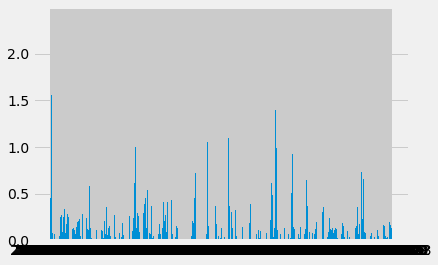

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results


# Calculate the date 1 year ago from the last data point in the database
results = session.query(func.max(Measurement.date)).all()
results[0]

last12 = dt.date(2017,8,23) - dt.timedelta(days=365)

last12



# Perform a query to retrieve the data and precipitation scores
results = session.query(func.avg(Measurement.prcp),Measurement.date).\
    filter(Measurement.date>=last12).\
    group_by(Measurement.date).all()

results



# Save the query results as a Pandas DataFrame and set the index to the date column
Prcp_df = pd.DataFrame(results,columns=["Prcp","Date"])
Prcp_df.head()
# Sort the dataframe by date
Prcp_df.sort_values("Date")
Prcp_df.head(15)
Prcp_df.set_index("Date")
# Use Pandas Plotting with Matplotlib to plot the data

plt.bar(Prcp_df["Date"],Prcp_df["Prcp"])
plt.show()


In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
Prcp_df.describe()



,Prcp
count,366.000000
mean,0.170757
std,0.295683
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [14]:
# Design a query to show how many stations are available in this dataset?
# stations = session.query(Measurement.station,func.count(Measurement.station)).\
#     group_by(Measurement.station).\
#     order_by(func.count(Measurement.station).desc()).all()

# stations

stations = session.query(func.count(distinct(Measurement.station))).all()
stations

[(9)]

In [15]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations = session.query(Measurement.station,func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

highesttemp = session.query(func.max(Measurement.tobs)).\
    filter(Measurement.station==stations[0][0]).all()

highesttemp

lowesttemp = session.query(func.min(Measurement.tobs)).\
    filter(Measurement.station==stations[0][0]).all()
lowesttemp

avgtemp = session.query(func.avg(Measurement.tobs)).\
    filter(Measurement.station==stations[0][0]).all()
avgtemp





[(71.66378066378067)]

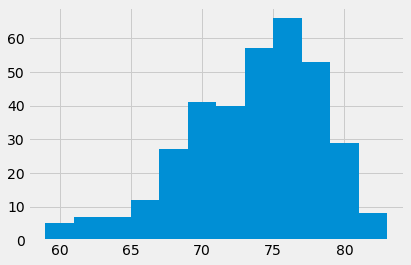

In [17]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# tempobs = session.query(Measurement.station,func.count(Measurement.tobs)).\
#     group_by(Measurement.station).\
#     order_by(func.count(Measurement.tobs).desc()).all()
# tempobs


tempobs= session.query(Measurement.tobs).\
    filter(Measurement.date >=last12).\
    filter(Measurement.station==stations[0][0]).\
    all()

temp = pd.DataFrame(tempobs,columns=["TempObs"])
plt.hist(temp["TempObs"],bins=12)
plt.show()





## Bonus Challenge Assignment

In [18]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [19]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
MyTemp =calc_temps('2017-08-01', '2017-08-22')
MyTemp

[(70.0, 78.75862068965517, 85.0)]

([<matplotlib.axis.XTick at 0x121e5e240>],
 <a list of 1 Text xticklabel objects>)

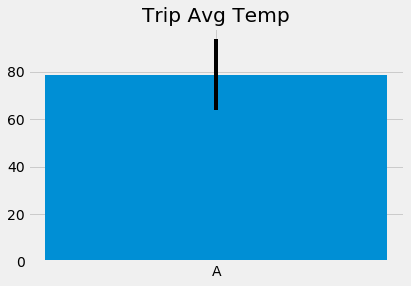

In [20]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
PTP = MyTemp[0][2]-MyTemp[0][0]
plt.bar(1,MyTemp[0][1],yerr=PTP)
plt.title('Trip Avg Temp')
tick_locations=[1]
plt.xticks(tick_locations,"Avg Temp")


In [21]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
# Cal total amt of rainfall per weather station ( station, sum.....)
TripStartDate ='2017-08-01'
TripEndDate='2017-08-22'
sel = [Measurement.station,Measurement.date,func.sum(Measurement.prcp),Station.name,Station.latitude,Station.longitude,Station.elevation]
results = session.query(*sel).\
            filter(Measurement.station==Station.station).\
            filter(Measurement.date > TripStartDate).\
            filter(Measurement.date < TripEndDate).\
            group_by(Measurement.station).\
            order_by(func.sum(Measurement.prcp).desc()).\
            all()


results


[('USC00516128',
  '2017-08-02',
  2.9,
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 ('USC00519281',
  '2017-08-04',
  0.5700000000000001,
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00519523',
  '2017-08-02',
  0.26,
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('USC00514830',
  '2017-08-02',
  0.24000000000000002,
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 ('USC00519397',
  '2017-08-02',
  0.04,
  'WAIKIKI 717.2, HI US',
  21.2716,
  -157.8168,
  3.0)]

In [22]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals('08-01')

[(67.0, 75.54, 83.0)]

In [27]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
normals =[]
Tmin = []
Tavg =[]
Tmax =[]
Tdts = []

TripStartDate =dt.date(2017,8,1)
TripEndDate=dt.date(2017,8,22)



Trip = pd.date_range(TripStartDate, TripEndDate)
Trip_range = Trip.strftime('%m-%d')

normals = [daily_normals(Trips) for Trips in Trip_range]

for j in Trip_range:
    Trip_results = daily_normals(j)
    Tmin.append(Trip_results[0][0])
    Tavg.append(Trip_results[0][1])
    Tmax.append(Trip_results[0][2])


for dts in Trip:
    Tdts.append(dts.date())

    
print(Tdts)
    



[datetime.date(2017, 8, 1), datetime.date(2017, 8, 2), datetime.date(2017, 8, 3), datetime.date(2017, 8, 4), datetime.date(2017, 8, 5), datetime.date(2017, 8, 6), datetime.date(2017, 8, 7), datetime.date(2017, 8, 8), datetime.date(2017, 8, 9), datetime.date(2017, 8, 10), datetime.date(2017, 8, 11), datetime.date(2017, 8, 12), datetime.date(2017, 8, 13), datetime.date(2017, 8, 14), datetime.date(2017, 8, 15), datetime.date(2017, 8, 16), datetime.date(2017, 8, 17), datetime.date(2017, 8, 18), datetime.date(2017, 8, 19), datetime.date(2017, 8, 20), datetime.date(2017, 8, 21), datetime.date(2017, 8, 22)]


In [33]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
Trip_df = pd.DataFrame({"Date":Tdts,"TripMin" : Tmin,"TripAvg":Tavg,"TripMax":Tmax})

Trip_df =Trip_df.set_index("Date")
# Trip_df['date'] = pd.date_range(start='8/1/2017', periods=len(Trip_df), freq='D')
# Trip_df

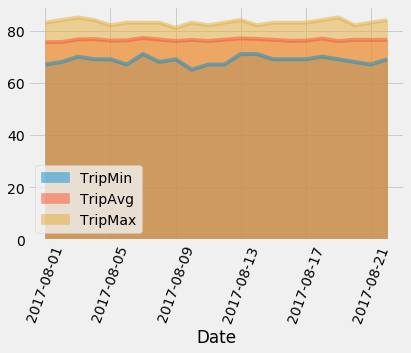

In [40]:
# Plot the daily normals as an area plot with `stacked=False`

fig = Trip_df.plot(kind="area",stacked=False,rot=70)
